# HW6 Reinforcement Learning

*   Author: Yuege Xie (EID:yx4256)
*   Python version: Python 3
*   CS 391L Machine Learning HW2

In [1]:
cd /content/drive/My Drive/2020-ml/reinforcement-learning

/content/drive/My Drive/2020-ml/reinforcement-learning


In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1023)
# check the python version
from platform import python_version
print("Current python version is {}".format(python_version()))
%matplotlib inline

Current python version is 3.6.9


In [0]:
class QTable:
    def __init__(self, env, lr=0.9, eps=0.1, gamma=0.9):
        self.env = env
        self.states = env.states
        self.actions = env.actions
        self.lr = lr
        self.eps = eps
        self.gamma = gamma
        self.qtable = {}
        # initiaize q table
        for s in self.states:
            self.qtable[s] = {}
            for a in self.actions:    
                self.qtable[s][a] = 0.0
    
    def get_action(self, state):
        if np.random.uniform() > self.eps:
            action = max(self.actions, key=lambda k: self.qtable[state][k])
        else:
            idx =  np.random.choice(len(self.actions))
            action = self.actions[idx]
        return action

    def update(self, state, training=False):
        action = self.get_action(state)
        next_state, reward = self.env.step(state, action)
        if training:
            if next_state[0] != self.env.col-1:
                q_next = reward + self.gamma * max(self.qtable[next_state].values())
            else:
                q_next = reward
            q_now = self.qtable[state][action]
            self.qtable[state][action] += self.lr * (q_next - q_now)
        return next_state

In [0]:
def plot_results(env, title):
    
    # plot grid
    fig = plt.figure(figsize=(18,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim(-.5, env.col-0.5)
    plt.ylim(-.5, env.row-0.5)
    y_minor_ticks = np.arange(0, env.row, 1)
    x_minor_ticks = np.arange(0, env.col, 1)
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_minor_ticks, minor=True)  
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(which='both')

    if env.obs:
        for ob in env.obs:
            plt.plot(ob[0], ob[1], 's', color='r', markersize=12)
            
    # plot initial and end points
    plt.plot(env.trace['init'][0], env.trace['init'][1] , 
             'D', color='g', markersize=12)
    env.end = env.trace['pos'][-1]
    plt.plot(env.end[0], env.end[1], 'D', color='g', markersize=12)

    # plot trace
    last = env.init
    for i in range(len(env.trace['pos'])):
        x, y = env.trace['pos'][i][0], env.trace['pos'][i][1]
        plt.scatter(x, y, color='orange', s=200, alpha=0.3)
        if env.trace['pos'][i] != last:
            dx, dy = env.trace['act'][i][0], env.trace['act'][i][1]
            plt.arrow(last[0], last[1], dx, dy, 
                  head_width=0.2, head_length=0.2, fc='k', ec='k')
        last = env.trace['pos'][i]
    plt.title(f"Simulation of Agent: {title}")
    plt.savefig(f"./plots/{title}.pdf")
    plt.show()  

## "Forth" Module

In [0]:
def check_step(state, col, row):
    state[0] = max(0, state[0])
    state[0] = min(col-1, state[0])
    state[1] = max(0, state[1])
    state[1] = min(row-1, state[1])
    return tuple([state[0], state[1]])

class EnvForth:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        self.states = [(a,b) for a in range(col) for b in range(row)]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)]
        self.obs = None
        
        np.random.seed(seed)
        self.init = (0, np.random.choice(row))
        self.trace = {'init': self.init,'act':[], 'pos':[]}

    # returns (abstract state, reward)
    def step(self, state, action): 
        next_state = [state[0]+action[0], state[1]+action[1]]
        next_state = check_step(next_state, self.col, self.row)
        reward_val = self.reward(state, action, next_state)
        self.trace['act'].append(action)
        self.trace['pos'].append(next_state)
        return next_state, reward_val

    def reward(self, state, action, next_state):
        # reach the goal
        if next_state[0] == self.col-1:
            return 100
        elif next_state[0] > state[0]: 
            return 5
        elif next_state[0] < state[0]: 
            return -5
        else:
            return 0

In [0]:
def train(env_class, episodes):
    env = env_class(col=25, row=6, seed=1023)
    qt = QTable(env)
    
    for ep in range(episodes):
        env = env_class(col=25, row=6, seed=23+np.random.randint(1000))
        next_state = env.init
        i = 0
        while next_state[0] != env.col-1 and i<2e2:
            next_state = qt.update(next_state, training=True)
            i=i+1
    return qt

In [0]:
def simulate(qt, env_class, seed):
    qt.eps = -1
    qt.env = env_class(col=25, row=6, seed=seed)

    next_state = qt.env.init
    i = 0
    while next_state[0] != qt.env.col-1 and i<2e2:
        next_state = qt.update(next_state, training=False)
        i=i+1
    return qt.env

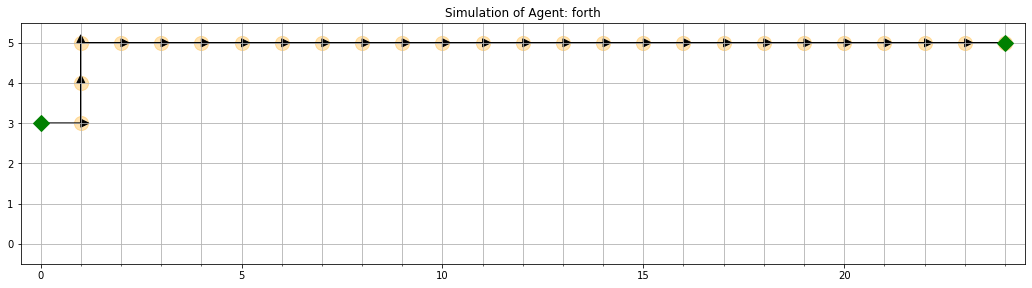

In [37]:
env_forth = EnvForth
qt_forth = train(env_forth, 100)
sample = simulate(qt_forth, env_forth, 23)
plot_results(sample, "forth")

## "Stay on the Path" Module

In [0]:
class EnvStay(EnvForth):
    def __init__(self, col , row, seed):
        super().__init__(col , row, seed)
    def reward(self, state, action, next_state):
        # reach the goal
        if next_state[0] == self.col-1:
            return 100
        elif next_state[0] > state[0]: 
            return 5
        elif next_state[0] < state[0]: 
            return -5
        elif next_state == state:
            return -20
        else:
            return 0 

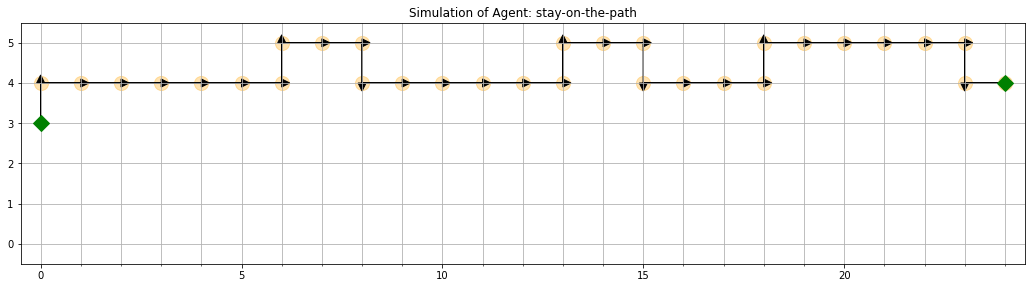

In [53]:
env_stay = EnvStay
qt_stay = train(env_stay, 50)
sample = simulate(qt_stay, env_stay, 23)
plot_results(sample, "stay-on-the-path")

## "Obstacles" Module

In [0]:
class EnvObstacles:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        self.pos = [(a,b) for a in range(col) for b in range(row)]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)] 
        
        np.random.seed(seed)
        self.init = (0, np.random.choice(row))
        num = col * row // 5
        x = np.random.randint(0, col, num)
        y = np.random.randint(0, row, num)
        self.obs = set([(x[i], y[i]) for i in range(len(x))])
        self.trace = {'init': self.init,'act':[], 'pos':[]}
        if self.init in self.obs:
            self.obs.remove(self.init)
        
        self.states = [()]

        

    # returns (abstract state, reward)
    def step(self, state, action):

        next_state = [state[0]+action[0], state[1]+action[1]]
        next_state = check_step(next_state, self.col, self.row)
        reward_val = self.reward(state, action, next_state)
        self.trace['act'].append(action)
        self.trace['pos'].append(next_state)
        return next_state, reward_val

    def reward(self, state, action, next_state):
        if next_state[0] == self.col-1:
            return 100
        if next_state[0] > state[0]: 
            return 5
        if next_state[0] < state[0]: 
            return -5
        elif next_state == state:
            return -20
        else:
            return 0 

In [0]:
envo = EnvObstacles(col=25, row=6, seed=1023)

IndexError: ignored

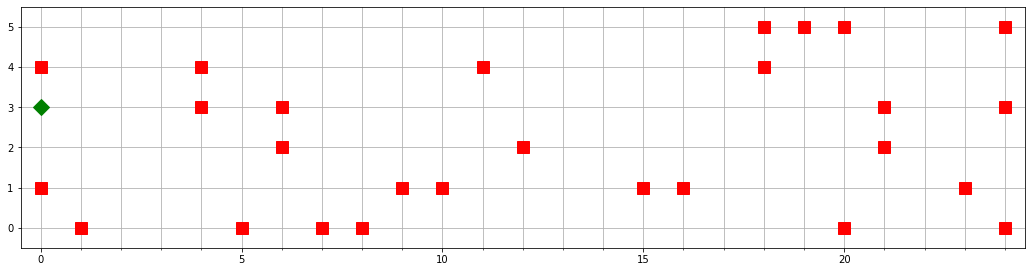

In [51]:
plot_results(envo, "obs")

## "Litter" Module

## Final Module